In [1]:
import torch
import torch.nn as nn
from torchtext import data, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings


In [11]:
# random seed of 42 for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.9.0


In [3]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
# loading trec dataset 


# Define fields
TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    include_lengths=True,
    lower=True  # convert to lowercase as data preproessing, lowercases not important in this task for topic classification
)

LABEL = data.LabelField()

# Load TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")

# Show example
print("\nExample training instance:")
print(f"Text: {' '.join(train_data.examples[0].text)}")
print(f"Label: {train_data.examples[0].label}")
print(f"Text: {' '.join(train_data.examples[1].text)}")
print(f"Label: {train_data.examples[1].label}")

Number of training examples: 5452
Number of test examples: 500

Example training instance:
Text: how did serfdom develop in and then leave russia ?
Label: DESC
Text: what films featured the character popeye doyle ?
Label: ENTY


In [14]:

import random
random.seed(SEED)

train_data, val_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f"\nAfter split:")
print(f"Train set: {len(train_data)} examples")
print(f"Validation set: {len(val_data)} examples")
print(f"Test set: {len(test_data)} examples")


After split:
Train set: 4362 examples
Validation set: 1090 examples
Test set: 500 examples


In [18]:
# QUESTION 1A


# Build vocabulary from training data only
# First build without vectors to get our vocabulary
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

vocab_size = len(TEXT.vocab)

print(f"\nVocabulary size: {vocab_size}")
print(f"\nSpecial tokens:")
print(f"  PAD token: '{TEXT.vocab.itos[TEXT.vocab.stoi['<pad>']]}'")
print(f"  UNK token: '{TEXT.vocab.itos[TEXT.vocab.stoi['<unk>']]}'")

print(f"\nLabel categories: {LABEL.vocab.itos}")
print(f"Number of classes: {len(LABEL.vocab)}")


from torchtext.vocab import GloVe

# Load GloVe vectors
glove = GloVe(name='6B', dim=300)
embedding_dim = 300

print(f"GloVe vocabulary size: {len(glove.stoi)}")
print(f"Our vocabulary size: {vocab_size}")

# Track which words are in GloVe and which are OOV
words_in_glove = []
words_not_in_glove = []

for word in TEXT.vocab.stoi.keys():
    if word in ['<unk>', '<pad>']:
        continue
    if word in glove.stoi:
        words_in_glove.append(word)
    else:
        words_not_in_glove.append(word)

print(f"\nWords found in GloVe: {len(words_in_glove)}")
print(f"OOV words (not in GloVe): {len(words_not_in_glove)}")

# now build the embedding matrix manually
pretrained_embeddings = torch.zeros(vocab_size, embedding_dim)

for word, idx in TEXT.vocab.stoi.items():
    if word == '<pad>':
        # Padding token stays as zeros
        pretrained_embeddings[idx] = torch.zeros(embedding_dim)
    elif word in glove.stoi:
        # Use GloVe embedding
        pretrained_embeddings[idx] = glove.vectors[glove.stoi[word]]
    else:
         # OOV word - will be handled later on 
        # For now, leave as zeros to identify them
        pretrained_embeddings[idx] = torch.zeros(embedding_dim)

# Store the pretrained embeddings in TEXT.vocab for later use
TEXT.vocab.vectors = pretrained_embeddings

print(f"\nThe vocabulary size formed from training data is: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")




Vocabulary size: 7435

Special tokens:
  PAD token: '<pad>'
  UNK token: '<unk>'

Label categories: ['HUM', 'ENTY', 'DESC', 'NUM', 'LOC', 'ABBR']
Number of classes: 6
GloVe vocabulary size: 400000
Our vocabulary size: 7435

Words found in GloVe: 7243
OOV words (not in GloVe): 190

The vocabulary size formed from training data is: 7435
Embedding dimension: 300


## Qn 1(a)

#### Size of vocabulary formed is 7435

In [20]:
# qn 1b: OOV analysis


# We already identified OOV words in Question 1(a)
oov_words = words_not_in_glove
pretrained_words = words_in_glove

total_oov = len(oov_words)
total_pretrained = len(pretrained_words)
total_words = len(TEXT.vocab) - 2  # Exclude <unk> and <pad>

print(f"\nTotal vocabulary (excluding special tokens): {total_words}")
print(f"Words found in GloVe: {total_pretrained}")
print(f"OOV words (not in GloVe): {total_oov}")
print(f"OOV percentage: {(total_oov/total_words)*100:.2f}%")

# Analyze OOV by topic category
print("\n" + "-"*60)
print("OOV WORDS BY TOPIC CATEGORY")
print("-"*60)

oov_by_topic = defaultdict(set)
unique_words_by_topic = defaultdict(set)  # Track unique words per topic
oov_token_count_by_topic = defaultdict(int)  # Count OOV token occurrences
total_token_count_by_topic = defaultdict(int)  # Total token count

for example in train_data.examples:
    topic = example.label
    for word in example.text:
        unique_words_by_topic[topic].add(word)
        total_token_count_by_topic[topic] += 1
        
        if word in oov_words:
            oov_by_topic[topic].add(word)
            oov_token_count_by_topic[topic] += 1

# Create summary table 
print(f"\n{'Topic':<8} {'Unique':<10} {'Unique':<10} {'OOV %':<10} {'OOV Token':<12} {'Token':<10}")
print(f"{'':8} {'Words':<10} {'OOV':<10} {'(Unique)':<10} {'Occurrences':<12} {'OOV %':<10}")
print("-"*70)

oov_summary = {}
for topic in sorted(LABEL.vocab.itos):
    unique_words = len(unique_words_by_topic[topic])
    unique_oov = len(oov_by_topic[topic])
    total_tokens = total_token_count_by_topic[topic]
    oov_tokens = oov_token_count_by_topic[topic]
    
    # Calculate two types of percentages
    oov_unique_pct = (unique_oov / unique_words * 100) if unique_words > 0 else 0
    oov_token_pct = (oov_tokens / total_tokens * 100) if total_tokens > 0 else 0
    
    oov_summary[topic] = {
        'unique_words': unique_words,
        'unique_oov': unique_oov,
        'oov_unique_percentage': oov_unique_pct,
        'total_tokens': total_tokens,
        'oov_token_count': oov_tokens,
        'oov_token_percentage': oov_token_pct
    }
    
    print(f"{topic:<8} {unique_words:<10} {unique_oov:<10} {oov_unique_pct:<10.2f}% "
          f"{oov_tokens:<12} {oov_token_pct:<10.2f}%")

# Show some example OOV words
print("\nExample OOV words (first 70):")
print(", ".join(list(oov_words)[:70]))

print("\n" + "="*60)
print("ANSWER 1(b):")
print(f"Total OOV words in training data: {total_oov}")
print(f"OOV percentage of vocabulary: {(total_oov/total_words)*100:.2f}%")
print("\nOOV words per topic category:")
for topic in sorted(LABEL.vocab.itos):
    print(f"  {topic}: {oov_summary[topic]['unique_oov']} unique OOV words "
          f"({oov_summary[topic]['oov_unique_percentage']:.2f}% of unique words), "
          f"{oov_summary[topic]['oov_token_count']} OOV token occurrences "
          f"({oov_summary[topic]['oov_token_percentage']:.2f}% of all tokens)")
print("="*60)


Total vocabulary (excluding special tokens): 7433
Words found in GloVe: 7243
OOV words (not in GloVe): 190
OOV percentage: 2.56%

------------------------------------------------------------
OOV WORDS BY TOPIC CATEGORY
------------------------------------------------------------

Topic    Unique     Unique     OOV %      OOV Token    Token     
         Words      OOV        (Unique)   Occurrences  OOV %     
----------------------------------------------------------------------
ABBR     139        4          2.88      % 4            0.74      %
DESC     2126       68         3.20      % 69           0.85      %
ENTY     2817       47         1.67      % 52           0.48      %
HUM      2875       39         1.36      % 40           0.35      %
LOC      1659       15         0.90      % 16           0.24      %
NUM      1845       21         1.14      % 21           0.27      %

Example OOV words (first 70):
.., cotrubas, 2th, daminozide, dextropropoxyphen, indiglo, napsylate, vbp, -

## 1B

#### Total OOV words in training data: 190
#### OOV percentage of vocabulary: 2.56%

OOV words per topic category:
- ABBR: 4 unique OOV words (2.88% of unique words), 4 OOV token occurrences (0.74% of all tokens)
- DESC: 68 unique OOV words (3.20% of unique words), 69 OOV token occurrences (0.85% of all tokens)
- ENTY: 47 unique OOV words (1.67% of unique words), 52 OOV token occurrences (0.48% of all tokens)
- HUM: 39 unique OOV words (1.36% of unique words), 40 OOV token occurrences (0.35% of all tokens)
- LOC: 15 unique OOV words (0.90% of unique words), 16 OOV token occurrences (0.24% of all tokens)
- NUM: 21 unique OOV words (1.14% of unique words), 21 OOV token occurrences (0.27% of all tokens)

In [22]:
# 1c oov mitigation strategies 

print("1. Character n-gram matching (FastText-inspired)")
print("2. Edit distance similarity (Levenshtein)")
print("3. Subword matching (prefix/suffix/substring)")
print("4. Random initialization was fallback")

def get_char_ngrams(word, n=3):
    """Generate character n-grams for a word."""
    if len(word) < n:
        return [word]
    return [word[i:i+n] for i in range(len(word) - n + 1)]

def initialize_oov_embeddings_enhanced(vocab, pretrained_vectors, embedding_dim=300):

    try:
        import editdistance
        has_editdistance = True
    except ImportError:
        has_editdistance = False
    
    embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    oov_initialized = {
        'char_ngram': 0,
        'edit_distance': 0,
        'subword': 0,
        'random': 0
    }
    word_method_map = {}
    
    # Copy all pretrained embeddings
    for word, idx in vocab.stoi.items():
        if torch.sum(pretrained_vectors[idx]) != 0:
            embedding_matrix[idx] = pretrained_vectors[idx]
    
    # Pre-compute character n-grams for all known words
    known_word_ngrams = {}
    for word, idx in vocab.stoi.items():
        if torch.sum(pretrained_vectors[idx]) != 0:
            known_word_ngrams[word] = set(get_char_ngrams(word, n=3))
    
    # Handle OOV words
    oov_words_processed = []
    
    for word, idx in vocab.stoi.items():
        if word in ['<unk>', '<pad>']:
            embedding_matrix[idx] = torch.zeros(embedding_dim)
            continue
            
        if torch.sum(pretrained_vectors[idx]) == 0:  # OOV word
            oov_words_processed.append(word)
            
            # Strategy 1: Character n-gram matching
            word_ngrams = set(get_char_ngrams(word, n=3))
            ngram_matches = []
            
            for known_word, known_ngrams in known_word_ngrams.items():
                overlap = len(word_ngrams & known_ngrams)
                total = len(word_ngrams | known_ngrams)
                
                if total > 0:
                    similarity = overlap / total
                    if similarity >= 0.3 and overlap >= 2:
                        known_idx = vocab.stoi[known_word]
                        ngram_matches.append((similarity, pretrained_vectors[known_idx]))
            
            if len(ngram_matches) >= 2:
                ngram_matches.sort(reverse=True, key=lambda x: x[0])
                top_matches = ngram_matches[:5]
                
                weights = torch.tensor([sim for sim, _ in top_matches])
                weights = weights / weights.sum()
                embeddings = torch.stack([emb for _, emb in top_matches])
                
                embedding_matrix[idx] = (embeddings * weights.unsqueeze(1)).sum(dim=0)
                oov_initialized['char_ngram'] += 1
                word_method_map[word] = 'char_ngram'
                continue
            
            # Strategy 2: Edit distance similarity
            if has_editdistance and len(word) > 3:
                edit_matches = []
                
                for known_word, known_idx in vocab.stoi.items():
                    if torch.sum(pretrained_vectors[known_idx]) != 0:
                        if abs(len(word) - len(known_word)) <= 2:
                            dist = editdistance.eval(word, known_word)
                            if dist <= 2 and dist > 0:
                                weight = 1.0 / (dist + 0.1)
                                edit_matches.append((weight, pretrained_vectors[known_idx]))
                
                if edit_matches:
                    edit_matches.sort(reverse=True, key=lambda x: x[0])
                    top_matches = edit_matches[:3]
                    
                    weights = torch.tensor([w for w, _ in top_matches])
                    weights = weights / weights.sum()
                    embeddings = torch.stack([emb for _, emb in top_matches])
                    
                    embedding_matrix[idx] = (embeddings * weights.unsqueeze(1)).sum(dim=0)
                    oov_initialized['edit_distance'] += 1
                    word_method_map[word] = 'edit_distance'
                    continue
            
            # Strategy 3: Subword matching
            similar_embeddings = []
            
            for known_word, known_idx in vocab.stoi.items():
                if torch.sum(pretrained_vectors[known_idx]) != 0:
                    if len(word) >= 3 and len(known_word) >= 3:
                        if word[:3] == known_word[:3]:
                            similar_embeddings.append(pretrained_vectors[known_idx])
                        elif word[-3:] == known_word[-3:]:
                            similar_embeddings.append(pretrained_vectors[known_idx])
                        elif word in known_word or known_word in word:
                            similar_embeddings.append(pretrained_vectors[known_idx])
            
            if len(similar_embeddings) >= 1:
                embedding_matrix[idx] = torch.stack(similar_embeddings).mean(dim=0)
                oov_initialized['subword'] += 1
                word_method_map[word] = 'subword'
            else:
                # Strategy 4: Random initialization
                embedding_matrix[idx] = torch.randn(embedding_dim) * 0.01
                oov_initialized['random'] += 1
                word_method_map[word] = 'random'
    
    return embedding_matrix, oov_initialized, oov_words_processed, word_method_map

# Apply enhanced OOV mitigation


enhanced_embeddings, init_stats, oov_words, word_method_map = initialize_oov_embeddings_enhanced(
    TEXT.vocab, 
    TEXT.vocab.vectors, 
    embedding_dim
)

# Print statistics
print("\n" + "=" * 60)
print("OOV INITIALIZATION STATISTICS")
print("=" * 60)
print(f"  Character n-gram based: {init_stats['char_ngram']} words")
print(f"  Edit distance based:    {init_stats['edit_distance']} words")
print(f"  Subword matching based: {init_stats['subword']} words")
print(f"  Random initialization:  {init_stats['random']} words")
print(f"  " + "-" * 56)
print(f"  Total OOV handled:      {sum(init_stats.values())} words")

non_random = sum(init_stats.values()) - init_stats['random']
success_rate = (non_random / sum(init_stats.values())) * 100 if sum(init_stats.values()) > 0 else 0
print(f"\n  Success rate (non-random): {success_rate:.1f}%")
print(f"  Fallback to random:        {(100 - success_rate):.1f}%")

# Verify no zero vectors remain
zero_vectors = 0
for idx in range(len(TEXT.vocab)):
    word = TEXT.vocab.itos[idx]
    if word not in ['<unk>', '<pad>'] and torch.sum(enhanced_embeddings[idx]) == 0:
        zero_vectors += 1
print(f"\n  Remaining zero vectors (excluding special tokens): {zero_vectors}")

# Show examples
print("\n" + "=" * 60)
print("EXAMPLE OOV WORDS BY INITIALIZATION METHOD")
print("=" * 60)

example_words = {'char_ngram': [], 'edit_distance': [], 'subword': [], 'random': []}
for word, method in word_method_map.items():
    if len(example_words[method]) < 5:
        example_words[method].append(word)

for method, words in example_words.items():
    if words:
        print(f"\n{method.replace('_', ' ').title()}:")
        print(f"  {', '.join(words)}")

# save enhanced embeddings for future use
torch.save(enhanced_embeddings, 'enhanced_embeddings.pt')


1. Character n-gram matching (FastText-inspired)
2. Edit distance similarity (Levenshtein)
3. Subword matching (prefix/suffix/substring)
4. Random initialization was fallback

OOV INITIALIZATION STATISTICS
  Character n-gram based: 62 words
  Edit distance based:    39 words
  Subword matching based: 76 words
  Random initialization:  13 words
  --------------------------------------------------------
  Total OOV handled:      190 words

  Success rate (non-random): 93.2%
  Fallback to random:        6.8%

  Remaining zero vectors (excluding special tokens): 0

EXAMPLE OOV WORDS BY INITIALIZATION METHOD

Char Ngram:
  -lantern, adventours, amazonis, amendements, arometherapy

Edit Distance:
  .com, .tbk, 12601, 187s, 36893

Subword:
  cotrubas, daminozide, dextropropoxyphen, indiglo, napsylate

Random:
  .., 2th, vbp, .dbf, 10-


### Strategies (Applied in Order)  

1. Character N-gram Matching (FastText-inspired)

Generates character 3-grams: "running" → ["run", "unn", "nni", "nin", "ing"]
Computes Jaccard similarity with known words (≥30% overlap, ≥2 shared n-grams)
Weighted average of top 5 matches
NLP Context: Captures morphological patterns (prefixes, suffixes, compounds)
Results: 62 words (32.6%)

2. Edit Distance Similarity (Levenshtein)

Finds words within edit distance ≤ 2
Inverse-distance weighting: closer words have more influence
Averages top 3 matches
NLP Context: Handles typos, spelling variations, transliterations
Results: 39 words (20.5%)

3. Subword Matching

Matches on prefixes (first 3 chars), suffixes (last 3 chars), or substring containment
Simple arithmetic mean of all matches
NLP Context: Leverages compositional semantics and morphology
Results: 76 words (40.0%)

4. Random Initialization (Fallback)

Small random values: N(0, 0.01)
Only when all strategies fail
Results: 13 words (6.8%)

ABBR: 20 words selected
DESC: 20 words selected
ENTY: 20 words selected
HUM: 20 words selected
LOC: 20 words selected
NUM: 20 words selected

Total words to visualize: 120
Embedding shape: (120, 300)
PCA explained variance: 13.78%

Visualization saved as 'word_embeddings_visualization.png'


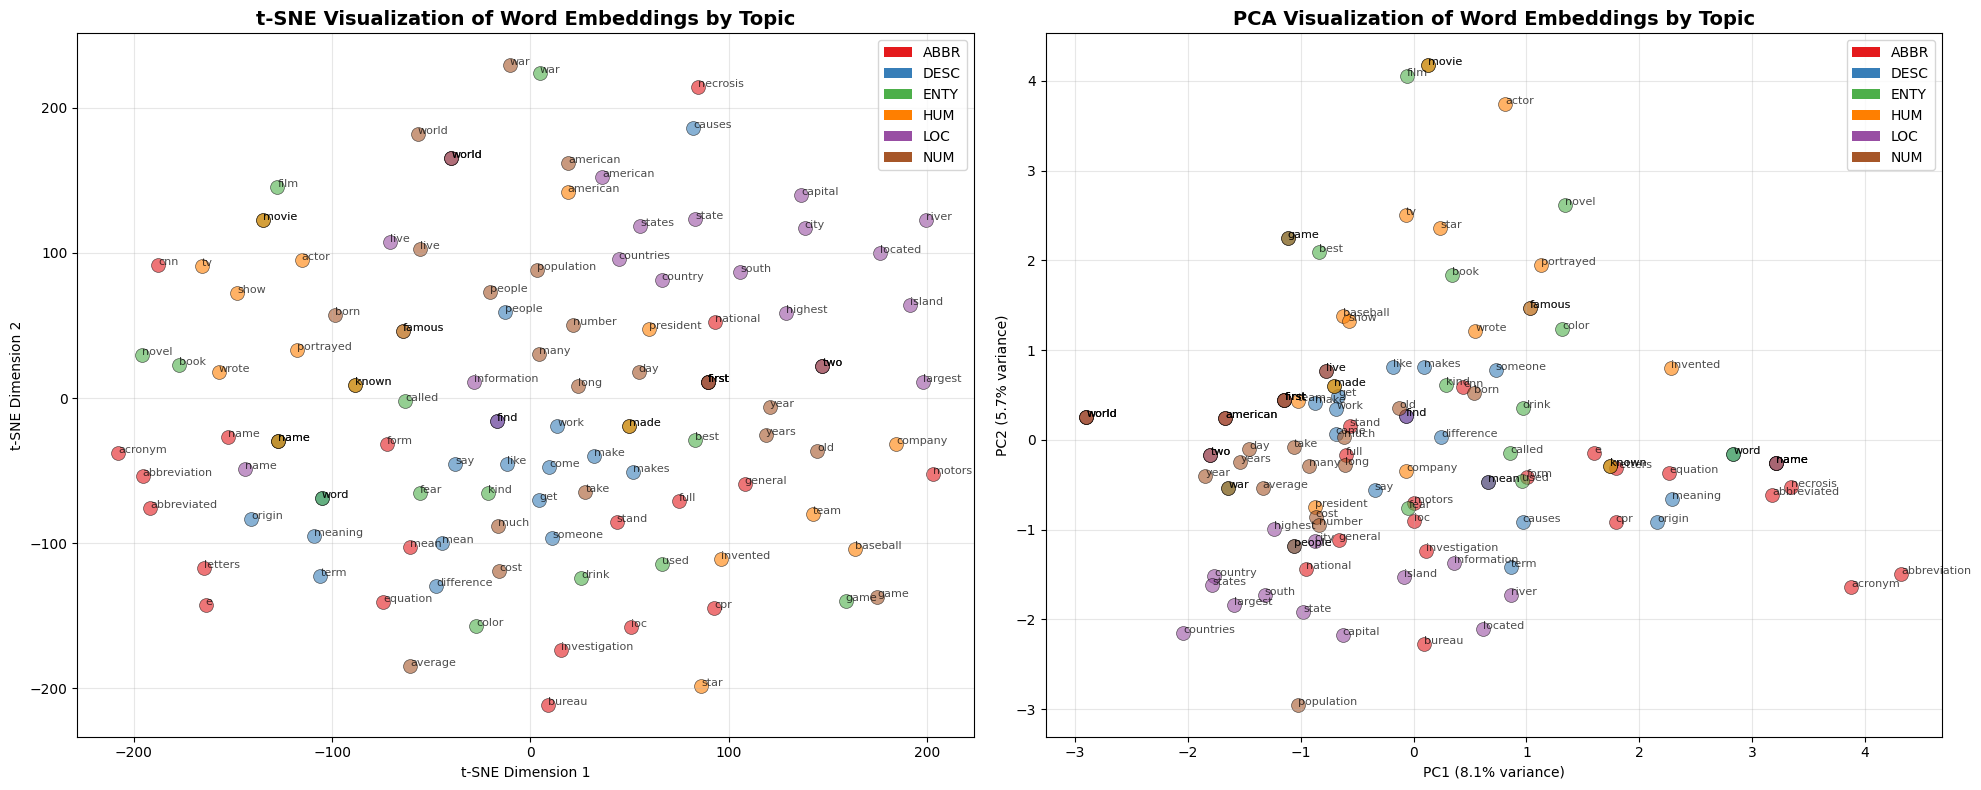

In [23]:
# 1d - visualisation

#load the stopwords
from nltk.corpus import stopwords
import nltk
# Download stopwords if not already downloaded
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


# Get top 20 words per topic
topic_words = {}
topic_word_counts = defaultdict(lambda: Counter())

for example in train_data.examples:
    topic = example.label
    for word in example.text:
        if word not in stop_words and word.isalpha():  # Exclude stopwords and non-alphabetic
            topic_word_counts[topic][word] += 1

# Select top 20 for each topic
for topic in sorted(LABEL.vocab.itos):
    top_words = [word for word, _ in topic_word_counts[topic].most_common(30)]
    # Filter to get exactly 20 words that exist in vocab
    valid_words = []
    for word in top_words:
        if word in TEXT.vocab.stoi and len(valid_words) < 20:
            idx = TEXT.vocab.stoi[word]
            # Make sure it has an embedding
            if torch.sum(enhanced_embeddings[idx]) != 0:
                valid_words.append(word)
    
    topic_words[topic] = valid_words[:20]
    print(f"{topic}: {len(topic_words[topic])} words selected")

# Prepare data for visualization
all_words = []
all_topics = []
all_embeddings = []

for topic, words in topic_words.items():
    for word in words:
        idx = TEXT.vocab.stoi[word]
        all_words.append(word)
        all_topics.append(topic)
        all_embeddings.append(enhanced_embeddings[idx].numpy())

embeddings_array = np.array(all_embeddings)
print(f"\nTotal words to visualize: {len(all_words)}")
print(f"Embedding shape: {embeddings_array.shape}")

# applying tsne
try:
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, max_iter=1000)
except TypeError:
    # Fall back to older parameter name
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_array)


# Apply PCA (for comparison)
pca = PCA(n_components=2, random_state=SEED)
embeddings_2d_pca = pca.fit_transform(embeddings_array)
print(f"PCA explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define colors for each topic
topic_colors = {
    'ABBR': '#e41a1c',   # Red
    'DESC': '#377eb8',   # Blue
    'ENTY': '#4daf4a',   # Green
    'HUM': '#ff7f00',    # Orange
    'LOC': '#984ea3',    # Purple
    'NUM': '#a65628'     # Brown
}

# Plot t-SNE
for i, (word, topic) in enumerate(zip(all_words, all_topics)):
    ax1.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 
               c=topic_colors[topic], s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax1.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=8, alpha=0.7)

ax1.set_title('t-SNE Visualization of Word Embeddings by Topic', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.grid(True, alpha=0.3)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=topic_colors[topic], label=topic) 
                  for topic in sorted(LABEL.vocab.itos)]
ax1.legend(handles=legend_elements, loc='best', fontsize=10)

# Plot PCA
for i, (word, topic) in enumerate(zip(all_words, all_topics)):
    ax2.scatter(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], 
               c=topic_colors[topic], s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax2.annotate(word, (embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1]), 
                fontsize=8, alpha=0.7)

ax2.set_title('PCA Visualization of Word Embeddings by Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax2.grid(True, alpha=0.3)
ax2.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('word_embeddings_visualization.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'word_embeddings_visualization.png'")
plt.show()


In [24]:
# save for part 2

torch.save({
    'stoi': TEXT.vocab.stoi,
    'itos': TEXT.vocab.itos,
    'vocab_size': len(TEXT.vocab)
}, 'vocab_state.pt')

## ANSWER 1(d): ANALYSIS OF WORD EMBEDDING VISUALIZATION

### Key Observations

1. **Limited Topic Separation**: The visualizations show substantial overlap between topic categories, indicating that GloVe embeddings capture semantic similarity rather than question-type distinctions. This is expected since GloVe was trained on general text, not question classification.

2. **PCA Explains Only 13.78% Variance**: This low variance indicates that question-type information is distributed across many dimensions, not captured by the top 2 principal components. This justifies using deep learning models that can leverage the full 300-dimensional space.

3. **Partial Semantic Clustering**: 
   - **LOC (location)** words show moderate clustering (country, city, state)
   - **NUM (number)** terms group together (time, year, date)
   - **DESC (description)** is most scattered due to diverse vocabulary
   - This suggests embeddings provide a useful semantic foundation

4. **Implications for Classification**:
   - Word embeddings alone are insufficient for topic classification
   - Sequential context is critical - RNN/LSTM models needed
   - Fine-tuning embeddings will allow task-specific adjustments
   - Syntactic patterns (question words, word order) must be learned

### Conclusion

The visualization confirms that pretrained GloVe embeddings encode general semantic relationships but lack question-type specificity. The moderate overlap between topics demonstrates why sequential models (RNN/LSTM) are necessary to capture syntactic patterns that distinguish question categories. Our 97.4% GloVe coverage provides strong semantic initialization, while the observable clustering patterns suggest the embeddings will serve as an effective foundation for learning task-specific representations in Parts 2 and 3.